<a id='head'></a>

# Отток клиентов

## Оглавление
 
- [**Введение**](#intro)
    - [Входные данные](#input_data)
    - [Ход исследования](#purpose)
    
- [**1. Обзор данных**](#review)
    - [1.1 Импорт библиотек и датасета](#review_01)
    - [1.2 Обзор данных](#review_02)
    - [Выводы](#review_conclusions)

- [**2. Подготовка данных**](#preprocessing)
    - [2.1 Предобработка данных](#preprocessing_01)
    - [2.2 Подготовка данных](#preprocessing_02)

- [**3. Исследование задачи**](#research)
    - [3.1 Исследование баланса классов](#research_01)
    - [3.2 Изучение модели без учёта дисбаланса](#research_02)
    - [Выводы](#research_conclusions)
    
- [**4. Борьба с дисбалансом**](#imbalance)
    - [4.1 Вес классов (class_weight)](#imbalance_01)
    - [4.2 Увеличение выборки (upsampled)](#imbalance_02)
    - [4.3 Уменьшение выборки (downsampled)](#imbalance_03)
    - [Выводы](#imbalance_conclusions)

- [**5. Тестирование модели**](#test)
    - [Выводы](#test_conclusions)

- [**6. Общие выводы**](#final_conclusion)

- [Чек лист](#check_list)

<a id='intro'></a>
## Введение [▴](#head)

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

Постройте модель с предельно большим значением **`F1-меры`**. Чтобы сдать проект успешно, нужно довести метрику до **`0.59`**. Проверьте **`F1-меру`** на тестовой выборке самостоятельно.

Дополнительно измеряйте **`AUC-ROC`**, сравнивайте её значение с **`F1-мерой`**.

<a id='input_data'></a>
### Входные данные [▴](#head)

Данные находятся в файле `/datasets/Churn.csv` (англ. **«отток клиентов»**).

**Признаки**
- **`RowNumber`** — индекс строки в данных
- **`CustomerId`** — уникальный идентификатор клиента
- **`Surname`** — фамилия
- **`CreditScore`** — кредитный рейтинг
- **`Geography`** — страна проживания
- **`Gender`** — пол
- **`Age`** — возраст
- **`Tenure`** — сколько лет человек является клиентом банка
- **`Balance`** — баланс на счёте
- **`NumOfProducts`** — количество продуктов банка, используемых клиентом
- **`HasCrCard`** — наличие кредитной карты
- **`IsActiveMember`** — активность клиента
- **`EstimatedSalary`** — предполагаемая зарплата

**Целевой признак**
- **`Exited`** — факт ухода клиента

<a id='purpose'></a>
### Ход исследования [▴](#head)

1. Загрузите и подготовьте данные. Поясните порядок действий.
2. Исследуйте баланс классов, обучите модель без учёта дисбаланса. Кратко опишите выводы.
3. Улучшите качество модели, учитывая дисбаланс классов. Обучите разные модели и найдите лучшую. Кратко опишите выводы.
4. Проведите финальное тестирование.

<a id='review'></a>
## 1. Обзор данных

<a id='review_01'></a>
### 1.1 Импорт библиотек и датасета [▴](#head)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

pd.options.mode.chained_assignment = None # Чтобы не вываливалась ошибка при масштабировании признаков

In [2]:
# для того чтобы код работал локально и на Практикуме применим конструкцию try-except

try:
    df = pd.read_csv('/datasets/Churn.csv') # для Практикума
except:
    df = pd.read_csv('datasets/Churn.csv') # локально

<a id='review_02'></a>
### 1.2 Обзор данных [▴](#head)

Для предварительного обзора данных используем заранее заготовленную функцию:

In [3]:
def overview(o_df):
    print('\nОбщий вид')
    display(o_df)
    
    print('\n.info()\n')
    print(o_df.info())
    
    print('\nЗаголовки')
    display(list(o_df.columns))
    
    print('\n.describe(числовых значений датафрейма)')
    display(o_df.describe())
    
    print('\n.describe(категориальных значений и дат)')
    display(o_df.select_dtypes(include=['object', 'datetime']).describe())

In [4]:
overview(df)


Общий вид


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1



.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None

Заголовки


['RowNumber',
 'CustomerId',
 'Surname',
 'CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited']


.describe(числовых значений датафрейма)


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000



.describe(категориальных значений и дат)


,Surname,Geography,Gender
count,10000,10000,10000
unique,2932,3,2
top,Smith,France,Male
freq,32,5014,5457


<a id='review_conclusions'></a>
### Выводы [▴](#head)

При предварительном осмотре данных выяснили следующие моменты:
- В столбце **`Tenure`** пропущенны значения, разберемся с ними на этапе предобработки.
- Столбцы: **`RowNumber`**, **`CustomerId`**, **`Surname`** - не несут для нашей модели никакой полезной информации и являются мусорными. Удалим их на этапе подготовки данных.
- Столбцы: **`Geography`**, **`Gender`** - имеют текстовый тип данных, требуется преобразовать их в числовой, техникой прямого кодирования **`OHE`**

<a id='preprocessing'></a>
## 2. Подготовка данных

<a id='preprocessing_01'></a>
### 2.1 Предобработка данных [▴](#head)

Разберемся с пропущенными значениями в столбце **`Tenure`**

In [5]:
print('Количество пропусков в столбце Tenure:', df.Tenure.isna().sum())
print('Что составляет: ', df.Tenure.isna().sum()/df.shape[0] * 100, '% от всех значений столбца', sep='')

Количество пропусков в столбце Tenure: 909
Что составляет: 9.09% от всех значений столбца


Пропущенные значения составляют **`9%`** от датафрейма. В теории даже если мы просто удалим эти значения, нам хватит данных для обучения. Но сначала посмотрим, сможем ли мы чем-то заполнить их.

Посмотрим какие значения и в каком количестве присутствуют в столбце **`Tenure`** (сколько лет челвоек является клиентом банка)

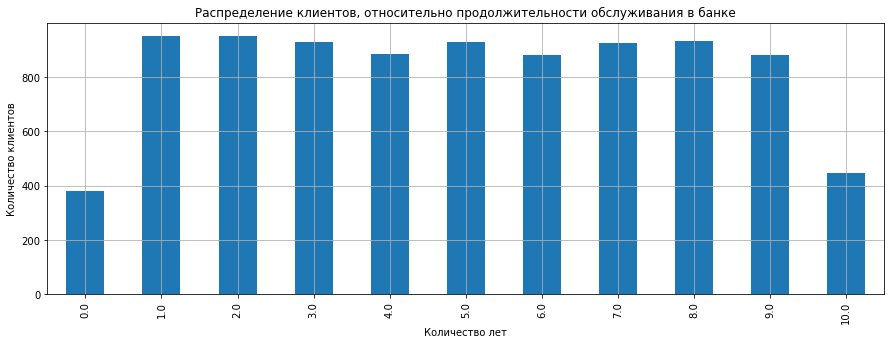

In [6]:
(
    df.Tenure
    .value_counts()
    .sort_index()
    .plot.bar(figsize=(15,5), grid=True)
)

plt.title('Распределение клиентов, относительно продолжительности обслуживания в банке')
plt.xlabel('Количество лет')
plt.ylabel('Количество клиентов')
plt.show()

Из диаграммы видно, что по количеству значений сильно отстают клиенты, которые обслуживаются в банке меньше одного года. По логике, таких клиентов наоборот должно быть большинство, так как банк постоянно набирает новых клиентов и с течением времени часть из них отваливается. Вполне возможно, что при заполнении таблицы вместо нуля в поле ничего не вписывали. По этому имеем **`NaN`**. Считаю разумным заполнить данные пропуски нулями.

In [7]:
df.Tenure.fillna(value=0, inplace=True)

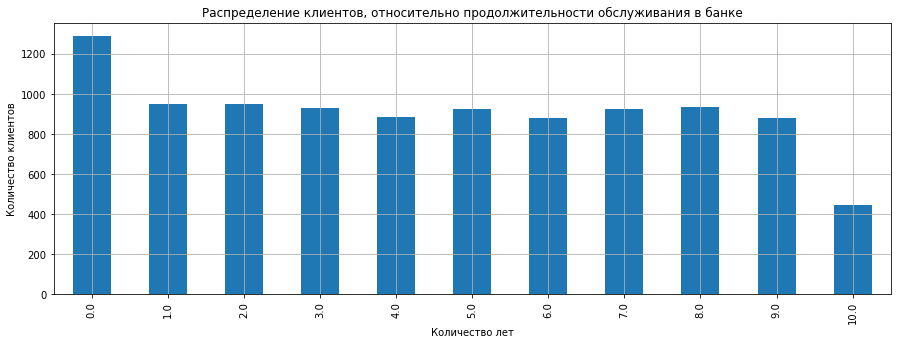

In [8]:
(
    df.Tenure
    .value_counts()
    .sort_index()
    .plot.bar(figsize=(15,5), grid=True)
)

plt.title('Распределение клиентов, относительно продолжительности обслуживания в банке')
plt.xlabel('Количество лет')
plt.ylabel('Количество клиентов')
plt.show()

Теперь картина выглядит более правдоподобно.

Еще раз проверим что все в порядке:

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Теперь разберемся с лишними столбцами.

Столбцы: **`RowNumber`**, **`CustomerId`**, **`Surname`** - содержат имена и ID клиентов, а так-же номера строк. Для нашей модели это просто белый шум, так как данная информация не несет никакой полезной нагрузки. Удалим эти столбцы из нашего датафрейма.

In [10]:
df.drop(['RowNumber', 'CustomerId' , 'Surname'], axis=1, inplace=True)

In [11]:
df.head(2)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0


<a id='preprocessing_02'></a>
### 2.2 Подготовка данных [▴](#head)

Переведем наши категориальные признаки в цифровые с помощью техники прямого кодирования **`OHE`**

In [12]:
df_ohe = pd.get_dummies(df, drop_first=True)

In [13]:
df_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


Теперь займемся подготовкой выборок.

Разделим выборку на **`3`** части в следующих пропорциях:
- Тренировочную - **`60%`**
- Валидационную - **`20%`**
- Тестовую - **`20%`**

In [14]:
print('Исходный размер датафрейма:', df_ohe.shape)

Исходный размер датафрейма: (10000, 12)


Делим исходный датафрейм:
- на обычные **`features`**
- и целевые **`target`** параметры

In [15]:
features = df_ohe.drop(['Exited'], axis=1)
target = df_ohe['Exited']

print('features:', features.shape)
print('target:', target.shape)

features: (10000, 11)
target: (10000,)


Теперь разделим датафрейм на тренировочную **`train`** и валидационную **`valid`** выборку в пропорции **`60 / 40`**. Не забудем стратифицировать целевые признаки.

In [16]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, 
    random_state=12345,
    test_size=0.4,
    stratify=target)

In [17]:
print('Тренирвочные:')
print('Доля:', len(features_train) / len(df), '| features:', features_train.shape)
print('Доля:', len(target_train) / len(df), '| target:', target_train.shape, '\n')

print('Валидационные:')
print('Доля:', len(features_valid) / len(df), '| features:', features_valid.shape)
print('Доля:', len(target_valid) / len(df), '| target:', target_valid.shape, '\n')

Тренирвочные:
Доля: 0.6 | features: (6000, 11)
Доля: 0.6 | target: (6000,) 

Валидационные:
Доля: 0.4 | features: (4000, 11)
Доля: 0.4 | target: (4000,) 



Для того чтобы получить тестовую **`test`** выборку, разделим нашу валидационную **`valid`** выборку в соотношении **`50/50`** 

In [18]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, 
    random_state=12345,
    test_size=0.5,
    stratify=target_valid)

Проверяем полученные выборки:

In [19]:
print('Тренирвочные:')
print('Доля:', len(features_train) / len(df), '| features:', features_train.shape)
print('Доля:', len(target_train) / len(df), '| target:', target_train.shape, '\n')

print('Валидационные:')
print('Доля:', len(features_valid) / len(df), '| features:', features_valid.shape)
print('Доля:', len(target_valid) / len(df), '| target:', target_valid.shape, '\n')
    
print('Тестовые:')
print('Доля:', len(features_test) / len(df), '| features:', features_test.shape)
print('Доля:', len(target_test) / len(df), '| target:', target_test.shape)

Тренирвочные:
Доля: 0.6 | features: (6000, 11)
Доля: 0.6 | target: (6000,) 

Валидационные:
Доля: 0.2 | features: (2000, 11)
Доля: 0.2 | target: (2000,) 

Тестовые:
Доля: 0.2 | features: (2000, 11)
Доля: 0.2 | target: (2000,)


Так как значения в зависимости от столбца могут отличаться на несколько порядков необъодимо выполнить **`масштабирование признаков`**.
<a id='scaler'></a>

In [20]:
numeric = list(features_train.columns)
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

display(features_train.head())

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
2837,-1.040434,0.953312,0.467449,0.774657,-0.914708,-1.525709,0.969466,-0.119110,1.739007,-0.575811,-1.102198
9925,0.454006,-0.095244,-1.461501,1.910540,-0.914708,0.655433,0.969466,-0.258658,-0.575041,-0.575811,-1.102198
8746,0.103585,-0.476537,1.110432,0.481608,0.820981,-1.525709,0.969466,1.422836,-0.575041,-0.575811,0.907278
660,-0.184996,0.190726,-1.461501,0.088439,-0.914708,0.655433,0.969466,-1.160427,1.739007,-0.575811,-1.102198
3610,-0.720933,1.620574,-1.140009,0.879129,-0.914708,0.655433,-1.031496,0.113236,-0.575041,-0.575811,-1.102198


Данные подготовлены, можно приступать к исследованию.

<a id='research'></a>
## 3. Исследование задачи

<a id='research_01'></a>
### 3.1 Исследование баланса классов [▴](#head)

Проанализируем какие классы преобладают в целевых признаках.

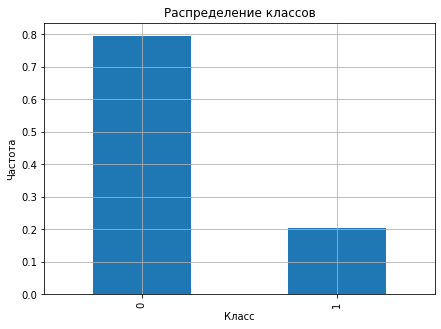

In [21]:
(
    df['Exited']
    .value_counts(normalize=df['Exited'].sum()/df.shape[0])
    .plot.bar(figsize=(7, 5), grid=True)
)

plt.title('Распределение классов')
plt.xlabel('Класс')
plt.ylabel('Частота')
plt.show()

Отрицательных классов в 4 раза больше чем положительных. Такое положение дел никуда не годится. Чуть ниже применим техники борьбы с дисбалансом. А пока посмотрим какие показатели выдют наши модели на несбалансированных данных.

<a id='research_02'></a>
### 3.2 Изучение модели без учёта дисбаланса [▴](#head)

Для того чтобы не плодить код, напишем функцию **`roc_f1`** для построения **`ROC кривой`**, а так же получения показателей **`AUC ROC`** и **`F1`**. Ниже по коду будем постоянно к ней обращаться.

In [22]:
def roc_f1(target, predicted, probabilities_one, x_fig_size=5, y_fig_size=4):
    
    fpr, tpr, thresholds = roc_curve(target, probabilities_one)

    plt.figure(figsize=(x_fig_size,y_fig_size))
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()
    
    f_one_score = f1_score(target, predicted)
    auc_roc = roc_auc_score(target, probabilities_one)
    
    print('F1 score:', f_one_score)
    print('AUC ROC:', auc_roc)

### Логистическая регрессия (disbalanced)

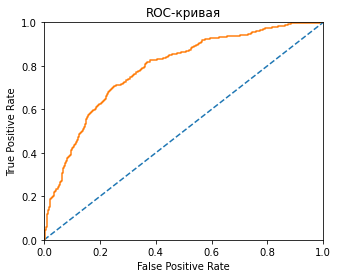

F1 score: 0.3076923076923077
AUC ROC: 0.7875729751699675


In [23]:
model = LogisticRegression(solver='liblinear', random_state=12345)
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

roc_f1(target_valid, predicted_valid, probabilities_one_valid) # вызываем нашу функцию

### Дерево решений (disbalanced)

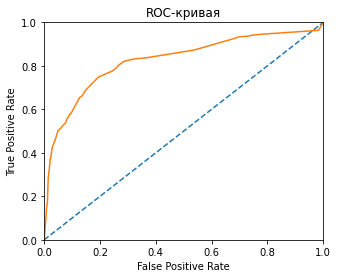

F1 score: 0.5924855491329479
AUC ROC: 0.8247056360232534
Лучшая модель: max_depth  = 7


In [24]:
best_model = None
best_depth = 0
best_result = 0

for depth in range(1, 15):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)        
    predicted_valid = model.predict(features_valid)
    f_one_score = f1_score(target_valid, predicted_valid)
    
    if f_one_score > best_result:
        best_depth = depth
        best_model = model
        best_result = f_one_score

best_model.fit(features_train, target_train)       
predicted_valid = best_model.predict(features_valid)

probabilities_valid = best_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

roc_f1(target_valid, predicted_valid, probabilities_one_valid)
print('Лучшая модель: max_depth  =', best_depth)

### Случайный лес (disbalanced)

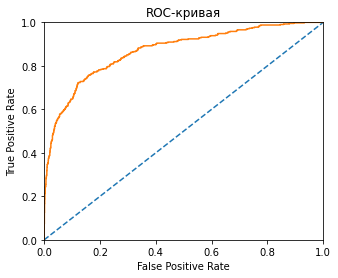

F1 score: 0.6024464831804281
AUC ROC: 0.8697023721548921
Лучшая модель: max_depth  = 9 | n_estimators = 20


In [25]:
best_model = None
best_depth = 0
best_result = 0
best_est = 0

for est in range(10, 51, 10):
    
    for depth in range(1, 10):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        
        f_one_score = f1_score(target_valid, predicted_valid)

        if f_one_score > best_result:
            best_est = est
            best_depth = depth
            best_model = model
            best_result = f_one_score

best_model.fit(features_train, target_train)       
predicted_valid = best_model.predict(features_valid)

probabilities_valid = best_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

roc_f1(target_valid, predicted_valid, probabilities_one_valid)
print('Лучшая модель: max_depth  =', best_depth, '| n_estimators =', best_est)

<a id='research_conclusions'></a>
### Выводы [▴](#head)

Самой слабой моделью на несбалансированных классах оказалась **`Логистическая регрессия`** на ней **`F1 score = 0.3`** При этом показатель **`AUC ROC = 0.78`**, что говорит нам о том, что сама по себе модель ведет себя адекватно, так как этот показатель ощутимо выше **`0.5`**

**`Дерево решений`** и **`Случайный лес`** оказались намного устойчивее к дисбалансу. Даже на несбалансированных данных мы смогли получить метрику **`F1 score`** на уровне **`0.59`**

Самый высокий показатель **`AUC ROC = 0.86`** мы получили на **`Случайном лесе`** возможно это лучшая модель для нашей задачи.

Посмотрим, сможем ли мы улучшить эти показатели, если разберемся с дисбалансом.

<a id='imbalance'></a>
## 4. Борьба с дисбалансом


<a id='imbalance_01'></a>
### 4.1 Вес классов (class_weight) [▴](#head)

Для того, чтобы выровнить вес классов применим параметр **`class_weight='balanced'`** к нашим моделям.

### Логистическая регрессия (balanced)

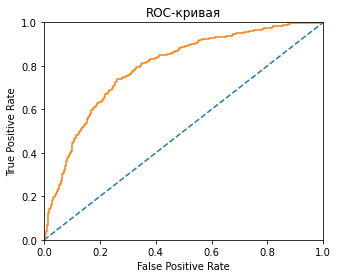

F1 score: 0.5285338015803336
AUC ROC: 0.7937219799980294


In [26]:
model = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

roc_f1(target_valid, predicted_valid, probabilities_one_valid)

### Дерево решений (balanced)

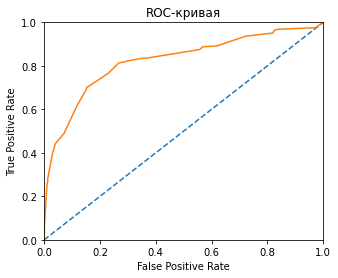

F1 score: 0.575925925925926
AUC ROC: 0.8234124051630702
Лучшая модель: max_depth  = 6


In [27]:
best_model = None
best_depth = 0
best_result = 0

for depth in range(1, 15):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model.fit(features_train, target_train)       
    predicted_valid = model.predict(features_valid)
    f_one_score = f1_score(target_valid, predicted_valid)
           
    if f_one_score > best_result:
        best_depth = depth
        best_model = model
        best_result = f_one_score


best_model.fit(features_train, target_train)       
predicted_valid = best_model.predict(features_valid)

probabilities_valid = best_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

roc_f1(target_valid, predicted_valid, probabilities_one_valid)
print('Лучшая модель: max_depth  =', best_depth)

### Случаный лес (balanced)

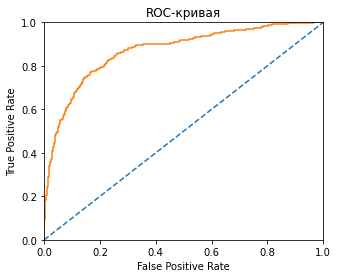

F1 score: 0.6434782608695652
AUC ROC: 0.8691758424475318
Лучшая модель: max_depth  = 8 | n_estimators = 40


In [28]:
best_model = None
best_depth = 0
best_result = 0
best_est = 0

for est in range(10, 51, 10):
    
    for depth in range(1, 10):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight='balanced')
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        
        f_one_score = f1_score(target_valid, predicted_valid)
        
        if f_one_score > best_result:
            best_est = est
            best_depth = depth
            best_model = model
            best_result = f_one_score

            
best_model.fit(features_train, target_train)       
predicted_valid = best_model.predict(features_valid)

probabilities_valid = best_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

roc_f1(target_valid, predicted_valid, probabilities_one_valid)
print('Лучшая модель: max_depth  =', best_depth, '| n_estimators =', best_est)

<a id='imbalance_02'></a>
### 4.2 Увеличение выборки (upsampled) [▴](#head)

Увеличим положительный класс в 4 раза.

In [29]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

Сравним распределение классов.

Размер исходной обучающей выборки: (6000, 11) (6000,)
Размер увеличенной обучающей выборки: (9666, 11) (9666,)


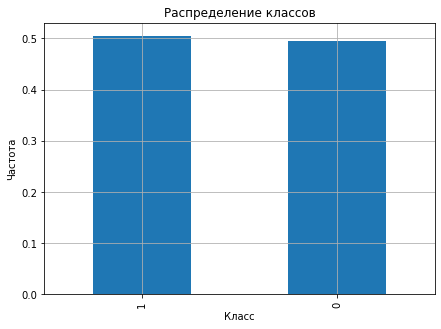

In [30]:
print('Размер исходной обучающей выборки:', features_train.shape, target_train.shape)
print('Размер увеличенной обучающей выборки:', features_upsampled.shape, target_upsampled.shape)

(
    target_upsampled
    .value_counts(normalize=df['Exited'].sum()/df.shape[0])
    .plot.bar(figsize=(7, 5), grid=True)
)

plt.title('Распределение классов')
plt.xlabel('Класс')
plt.ylabel('Частота')
plt.show()

Все отлично, можем приступать к исследованию.

### Логистическая регрессия (upsampled)

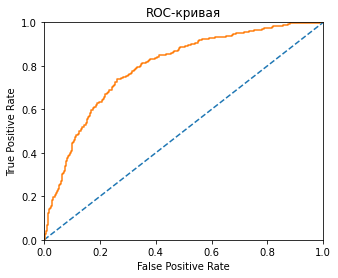

F1 score: 0.5246753246753246
AUC ROC: 0.7938051162676125


In [31]:
model = LogisticRegression(solver='liblinear', random_state=12345)
model.fit(features_upsampled, target_upsampled)

predicted_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

roc_f1(target_valid, predicted_valid, probabilities_one_valid)

### Дерево решений (upsampled)

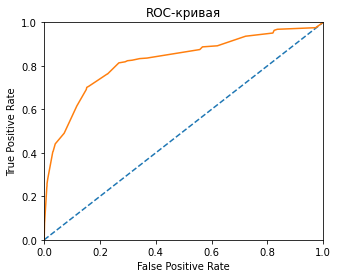

F1 score: 0.575925925925926
AUC ROC: 0.8234278007685487
Лучшая модель: max_depth  = 6


In [32]:
best_model = None
best_depth = 0
best_result = 0

for depth in range(1, 15):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_upsampled, target_upsampled)          
    predicted_valid = model.predict(features_valid)
    f_one_score = f1_score(target_valid, predicted_valid)
  
    if f_one_score > best_result:
        best_depth = depth
        best_model = model
        best_result = f_one_score
        
best_model.fit(features_upsampled, target_upsampled)     
predicted_valid = best_model.predict(features_valid)

probabilities_valid = best_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

roc_f1(target_valid, predicted_valid, probabilities_one_valid)
print('Лучшая модель: max_depth  =', best_depth)

### Случаный лес (upsampled)

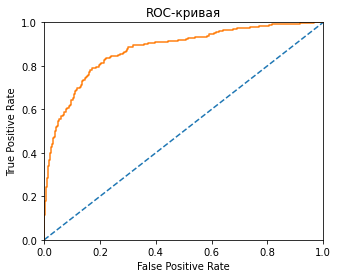

F1 score: 0.6408602150537634
AUC ROC: 0.8742271406049857
Лучшая модель: max_depth  = 9 | n_estimators = 50


In [33]:
best_model = None
best_depth = 0
best_result = 0
best_est = 0

for est in range(10, 51, 10):
    
    for depth in range(1, 10):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_upsampled, target_upsampled)
        predicted_valid = model.predict(features_valid)
        
        f_one_score = f1_score(target_valid, predicted_valid)

        if f_one_score > best_result:
            best_est = est
            best_depth = depth
            best_model = model
            best_result = f_one_score

best_model.fit(features_upsampled, target_upsampled)     
predicted_valid = best_model.predict(features_valid)

probabilities_valid = best_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

roc_f1(target_valid, predicted_valid, probabilities_one_valid)

print('Лучшая модель: max_depth  =', best_depth, '| n_estimators =', best_est)

<a id='imbalance_03'></a>
### 4.3 Уменьшение выборки (downsampled) [▴](#head)

Уменьшим отрицательный класс в 4 раза.

In [34]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

Сравним распределение классов.

Размер исходной обучающей выборки: (6000, 11) (6000,)
Размер уменьшенной обучающей выборки: (2416, 11) (2416,)


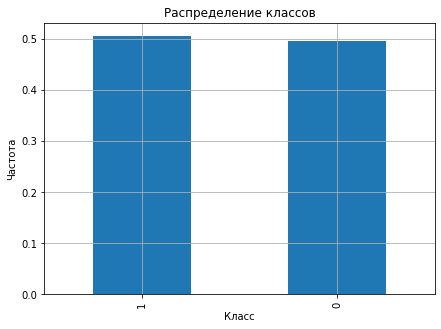

In [35]:
print('Размер исходной обучающей выборки:', features_train.shape, target_train.shape)
print('Размер уменьшенной обучающей выборки:', features_downsampled.shape, target_downsampled.shape)

(
    target_downsampled
    .value_counts(normalize=df['Exited'].sum()/df.shape[0])
    .plot.bar(figsize=(7, 5), grid=True)
)

plt.title('Распределение классов')
plt.xlabel('Класс')
plt.ylabel('Частота')
plt.show()

Все отлично, можем приступать к исследованию.

### Логистическая регрессия (downsampled)

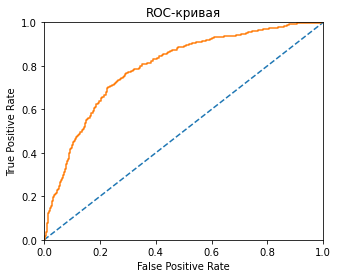

F1 score: 0.5271317829457364
AUC ROC: 0.792599640358656


In [36]:
model = LogisticRegression(solver='liblinear', random_state=12345)
model.fit(features_downsampled, target_downsampled)

predicted_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

roc_f1(target_valid, predicted_valid, probabilities_one_valid)

### Дерево решений (downsampled)

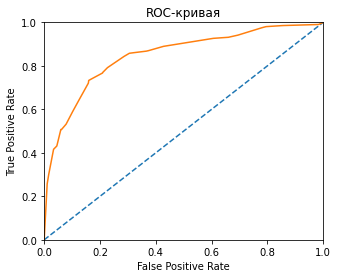

F1 score: 0.5939278937381405
AUC ROC: 0.8472324859592077
Лучшая модель: max_depth  = 6


In [37]:
best_model = None
best_depth = 0
best_result = 0

for depth in range(1, 15):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_downsampled, target_downsampled)        
    predicted_valid = model.predict(features_valid)
    f_one_score = f1_score(target_valid, predicted_valid)
    
    if f_one_score > best_result:
        best_depth = depth
        best_model = model
        best_result = f_one_score
        
best_model.fit(features_downsampled, target_downsampled)    
predicted_valid = best_model.predict(features_valid)

probabilities_valid = best_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

roc_f1(target_valid, predicted_valid, probabilities_one_valid)
print('Лучшая модель: max_depth  =', best_depth)

### Случаный лес (downsampled)

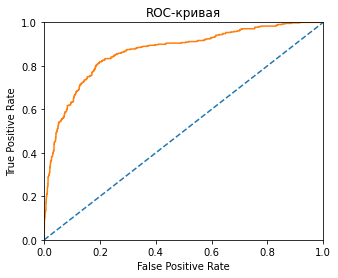

F1 score: 0.6310772163965682
AUC ROC: 0.8660913328899399
Лучшая модель: max_depth  = 6 | n_estimators = 30


In [38]:
best_model = None
best_depth = 0
best_result = 0
best_est = 0

for est in range(10, 51, 10):
    
    for depth in range(1, 10):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_downsampled, target_downsampled)
        predicted_valid = model.predict(features_valid)
        
        f_one_score = f1_score(target_valid, predicted_valid)

        if f_one_score > best_result:
            best_est = est
            best_depth = depth
            best_model = model
            best_result = f_one_score

best_model.fit(features_downsampled, target_downsampled)   
predicted_valid = best_model.predict(features_valid)

probabilities_valid = best_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

roc_f1(target_valid, predicted_valid, probabilities_one_valid)
print('Лучшая модель: max_depth  =', best_depth, '| n_estimators =', best_est)

Для удобства сравнения, все результаты запишем в таблицы.

Чтобы не растягивать проект еще на 10 листов, исследования моделей на **`немасштабированных данных`** я провел отдельно и вписал результаты в таблицу.

При необходимости проверить результаты, можно закомментировать [**вот этот блок**](#scaler) и перезапустить выполнение тетрадки.

### Результаты исследований без масштабирования признаков (F1 score)

Метод балансировки класса|Логистическая регрессия|Дерево Решений|Случайный Лес
-|-|-|-
С дисбалансом классов|0.062|0.592|0.602
Вес классов|0.502|0.575|0.644
Увеличение выборки|0.475|0.575|0.640
Уменьшение выборки|0.475|0.593|0.630

### Результаты исследований с масштабированием признаков (F1 score)

Метод балансировки класса|Логистическая регрессия|Дерево Решений|Случайный Лес
-|-|-|-
С дисбалансом классов|0.307|0.592|0.602
Вес классов|0.528|0.575|0.643
Увеличение выборки|0.524|0.575|0.640
Уменьшение выборки|0.527|0.593|0.631

<a id='imbalance_conclusions'></a>
### Выводы [▴](#head)

**`AUC ROC`** во всех экспериментах оказалась выше **`0.8`** или очень близко к этому значению. Это означает, что модели ведут себя адекватно.

Хуже всего с дисбалансом классов справляется **`Логистическая регрессия`**, а на немасштабированных данных вообще показывает ужасный результат **`F1 = 0.06`**

**`Дерево решений`** весьма странно повело себя при балансировке классов и умудрилось даже немного ухудшить результат.

А вот **`Случайный лес`** наоборот ощутимо улучшил свои показатели на сбалансированных входных данных и показал лучший результат со следующими гиперпараметрами:
- `n_estimators=40`
- `max_depth=8`
- `class_weight='balanced'`

Используем эти параметры, чтобы провести финальное тестирование.

<a id='test'></a>
## 5. Тестирование модели


Лучший результат на валидационной выборке показала следующая комбинация:
- Модель: **`Случайный лес`**
- Балансировка классов методом: **`class_weight='balanced'`**
- Гиперпараметры: **`n_estimators=40`**, **`max_depth=8`**

Результаты на валидационной выборке:
- **`F1 score: 0.643`**
- **`AUC ROC: 0.869`**

Сравним эти результаты на тестовой выборке:

Для того, чтобы получить более объективные результаты объединим выборки **`train`** и **`valid`**

In [39]:
features_train_valid = pd.concat([features_train] + [features_valid]) # features
target_train_valid = pd.concat([target_train] + [target_valid]) # target

features_train_valid, target_train_valid = shuffle(features_train_valid, target_train_valid, random_state=12345)

In [40]:
print(features_train_valid.shape)
print(target_train_valid.shape)

(8000, 11)
(8000,)


Теперь прогоним обновленные данные на тестовой выборке:

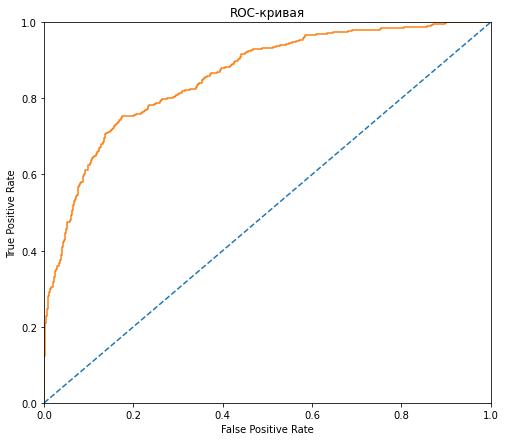

F1 score: 0.6256742179072277
AUC ROC: 0.8579288070813494


In [41]:
model = RandomForestClassifier(random_state=12345, n_estimators=40, max_depth=8, class_weight='balanced')
model.fit(features_train_valid, target_train_valid)
predicted_test = model.predict(features_test)

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

roc_f1(target_test, predicted_test, probabilities_one_test, x_fig_size=8, y_fig_size=7)

<a id='test_conclusions'></a>
### Выводы [▴](#head)

На тестовой выборке результаты оказались чуть хуже, возможно модель немного переобучилась. Однако потеря качества в **`2`** процентных пункта вполне приемлема, так как мы преодолели в целевой порог в **`0.59`**

Метрика|Валидационная выборка|Тестовая выборка
-|-|-
F1 score|0.643|0.625
AUC ROC|0.869|0.857



<a id='final_conclusion'></a>
## 6. Общие выводы

Мы рассмотрели как ведут себя модели относительно `масшитабирования признаков`, а так же `баланса классов`.

**`Логистическая регрессия`** оказалась самой слабой моделью. Она крайне подвержена `дисбалансу классов`, а на `немасштабированных признаках` показывает совсем плачевный результат. Как следствие работа с неподготовленными данными на этой модели в принципе невозможна.

**`Дерево решений`** оказалось достаточно устойчиво к работе на `немасштабированных признаках`, а также устойчиво к `дисбалансу классов` в пропорции `1/4`, возможно если дисбаланс будет более выразительным, модель ухудшит свои показатели.

**`Случайный лес`** показал лучший результат. Помимо устойчивости к работе на `немасштабированных признаках` и `дисбалансе классов` в пропорциях `1/4` результат получилось еще немного улучшить благодаря `балансировке классов`.

